In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import numpy_financial as npf
import datetime as dt
import scipy.optimize as optimize
from dateutil.relativedelta import relativedelta
import math
from scipy.interpolate import interp1d
import scipy.stats




df = pd.read_csv(r'C:\Users\Aakash\Documents\APM466\A1_Data.csv', header = None).set_index(0).loc[:, ::2].dropna(axis=0, how = 'all')
df.columns = range(df.columns.size)
df.index.name = "Dates"
df.iloc[1] = (df.iloc[1]).astype(float)
df.iloc[5:-1] = df.iloc[5:-1].astype(float)
df = df.iloc[:,0:30]

#df = (df.T)[(df.T)['CPN']<2].T
df.iloc[3] = pd.to_datetime((df.T)['ISSUE_DT'])
df = ((df.T)[((df.T)['ISSUE_DT'] > '2019-09-01 07:30:00') & ((df.T)['ISSUE_DT'] < '2023-07-23 09:00:00')]).T
df = df.drop(labels = [0,5,8,13,16],axis=1)
df.columns = range(df.columns.size)


px_data = df.iloc[5:-1]
px_data.index = pd.to_datetime(px_data.index)
bond_data = df.iloc[:5]

issue = pd.to_datetime(bond_data.iloc[3,:])
mat = pd.to_datetime(bond_data.iloc[4,:])

coups = bond_data.T['CPN']
bond_data

,0,1,2,3,4,5,6,7,8,9,10
Dates,,,,,,,,,,,
ZQ4084443,ZP6776824@BGN Corp,BK9320544@BGN Corp,BN9038405@BGN Corp,BQ9098642@BGN Corp,ZO9618760@BGN Corp,BQ4678315@BGN Corp,ZQ0603485@BGN Corp,BH5185468@BGN Corp,ZO8493611@BGN Corp,BP1003147@BGN Corp,BR9532150@BGN Corp
CPN,1.5,0.25,0.25,0.5,0.25,0.75,1.25,0.5,0.25,1.0,1.25
ID_ISIN,CA135087K866,CA135087L369,CA135087L856,CA135087M763,CA135087L690,CA135087M508,CA135087K528,CA135087K940,CA135087L518,CA135087L930,CA135087M847
ISSUE_DT,2020-01-27 00:00:00,2020-08-17 00:00:00,2021-02-05 00:00:00,2021-08-09 00:00:00,2020-10-16 00:00:00,2021-07-12 00:00:00,2019-10-11 00:00:00,2020-04-03 00:00:00,2020-10-09 00:00:00,2021-04-16 00:00:00,2021-10-15 00:00:00
MATURITY,5/1/2022,11/1/2022,5/1/2023,11/1/2023,4/1/2024,10/1/2024,3/1/2025,9/1/2025,3/1/2026,9/1/2026,3/1/2027


In [192]:
def ytm_coup_BEY(settle, mat, coup, cln_px): # semi annual yield * 2 (Bond equiv yield)
    t = (relativedelta(mat, settle).years*2 + relativedelta(mat, settle).months/6)//1 # number of full coupon payments until maturity
    prev_coup_date = mat - relativedelta(months=6*(t+1))
    next_coup_date = mat - relativedelta(months=6*(t))
    
    w = (next_coup_date-settle).days/(next_coup_date-prev_coup_date).days # w periods til next coup

    AI = coup*(settle-prev_coup_date).days/365 # act/365 accrued interest per canadian bond mkt conventions
    dirty_px = cln_px + AI
    
    y = 0.015
    ytm_func = lambda y: (coup/2 * ((1 - 1/((1+y/2)**(t+1))) / (y/2)) + 100 / ((1+y/2)**(t+1))) / ((1/(1+y/2))**(1-w)) - dirty_px
    
    ytm = optimize.newton(ytm_func, 0.015,maxiter=10000)

    return ytm*100

def ytm_cts(settle, mat, coup, cln_px): #continously compounded YTM
    semi_bond_ytm = ytm_coup_BEY(settle, mat, coup, cln_px)/100
    rate = 2*math.log(1+semi_bond_ytm/2)
    return rate*100

<AxesSubplot:title={'center':'0-5y CAN Market Convention Yield to Maturity Curve'}, xlabel='Maturity Date', ylabel='Yield (Annual, %)'>

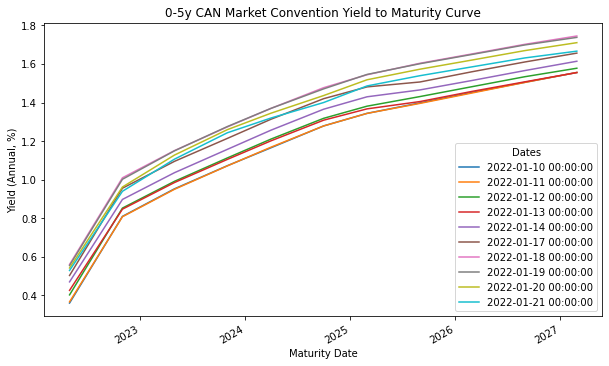

In [257]:
# YTM curve

outer = []
outer_cts = []
for i in range(len(px_data.index)):
    inner = []
    inner_cts = []
    for j in range(len(mat)):
        bond_num = j
        date_num = i
        x = ytm_coup_BEY(px_data.index[date_num],mat[bond_num], float(bond_data[bond_num][1]), float(px_data[bond_num][date_num]))
        y = ytm_cts(px_data.index[date_num],mat[bond_num], float(bond_data[bond_num][1]), float(px_data[bond_num][date_num]))
        inner+=[x]
        inner_cts+=[y]
    outer+=[inner]
    outer_cts+=[inner_cts]
    
outer = pd.DataFrame(outer)
outer.columns = mat
outer.index = px_data.index#.strftime('%Y-%m-%d')
outer.T.plot(figsize=(10,6),title='0-5y CAN Market Convention Yield to Maturity Curve', ylabel = 'Yield (Annual, %)', xlabel = "Maturity Date")

#outer_cts = pd.DataFrame(outer_cts)
#outer_cts.columns = mat
#outer_cts.index = px_data.index
#outer_cts.T.plot(figsize=(10,7),title='0-5y CAN Continuously Compounded Yield to Maturity Curve')

MATURITY,2022-05-01,2022-11-01,2023-05-01,2023-11-01,2024-04-01,2024-10-01,2025-03-01,2025-09-01,2026-03-01,2026-09-01,2027-03-01
Dates,,,,,,,,,,,
2022-01-10,0.721788,0.810218,0.953303,1.074651,1.167164,1.285303,1.357321,1.404554,1.456243,1.523337,1.582657
2022-01-11,0.734189,0.808380,0.950898,1.073830,1.170155,1.285064,1.357060,1.402035,1.453173,1.522711,1.582823
2022-01-12,0.806339,0.853143,0.992200,1.114952,1.212189,1.324788,1.394791,1.437482,1.485952,1.552561,1.604856
2022-01-13,0.853136,0.847636,0.985947,1.107359,1.203131,1.315039,1.380597,1.411413,1.461438,1.525599,1.581985
2022-01-14,0.941261,0.897944,1.036942,1.159511,1.258415,1.372133,1.443773,1.471983,1.518098,1.584636,1.641501
2022-01-17,1.007784,0.956124,1.095759,1.216370,1.315151,1.426925,1.495491,1.513232,1.563471,1.629500,1.684120
2022-01-18,1.121905,1.010161,1.151485,1.276030,1.371472,1.484155,1.558881,1.610811,1.656162,1.722256,1.774502
2022-01-19,1.110915,1.002505,1.150255,1.277816,1.371460,1.477925,1.560506,1.608414,1.653440,1.718920,1.767064
2022-01-20,1.085419,0.962344,1.128317,1.261756,1.346461,1.443127,1.532614,1.579872,1.624319,1.689267,1.739220


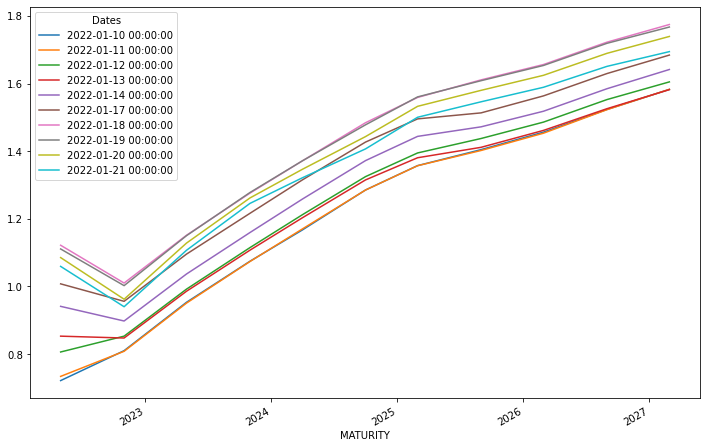

In [194]:
# Spot Curve Boostrap
def bootstrap_annual(settle, mat, coups, px_data):
    outer = []
    for date_num in range(len(settle)):
        spot_rates = []
        for bond_num in range(len(mat)):
            coup = coups[bond_num]
            diff = (mat[bond_num].year-settle[date_num].year)*12+mat[bond_num].month-settle[date_num].month
            
            t = (relativedelta(mat[bond_num], settle[date_num]).years*2 + relativedelta(mat[bond_num], settle[date_num]).months/6)//1
            # number of full coupon payments until maturity
            prev_coup_date = mat[bond_num] - relativedelta(months=6*(t+1))
            next_coup_date = mat[bond_num] - relativedelta(months=6*(t))         
            AI = coup*(settle[date_num]-prev_coup_date).days/365 # act/365 accrued interest per canadian bond mkt conventions
            dirty_px = float(px_data[bond_num][date_num]) + AI           
            w = (next_coup_date-settle[date_num]).days/(next_coup_date-prev_coup_date).days #stub period
            
            if diff<6:
                spot = (((coup/2+100)/dirty_px)**(1/(t+w))-1)*2
            
            else: 
                # using industry standard linear interp
                spot_interp = []
                coup_dates = np.arange(w,t+w,1)
                
                periods_to_mat = ((mat[:bond_num+1] - settle[date_num]).dt.days*2)/365 # approx (not incl leap years)
                periods_to_mat[bond_num] = t+w # accuracy adjustment
                periods_to_mat = np.array(pd.concat([pd.DataFrame([0],index = [settle[date_num]]),periods_to_mat]).reset_index(drop=True)[0])
                
                yields = [0.18/100] + spot_rates # overnight repo rate (CORRA) + end point extrapolation
                
                slope = (yields[-1]-yields[-2])/(periods_to_mat[-2]-periods_to_mat[-3])
                endpoint = slope*(periods_to_mat[-1]-periods_to_mat[-2])+yields[-1]
                
                yields = yields + [endpoint]                
                
                interp = interp1d(periods_to_mat, yields, bounds_error=True, fill_value=scipy.nan)
                for i in coup_dates:
                    val = float(interp(i))
                    if not np.isnan(val):
                         spot_interp.append(val)
                sum_ = 0
                for j in range(int(t)):
                    sum_ += (1/(1+spot_interp[j]/2))**(j+w)
                spot = (((coup/2+100)/(dirty_px-coup*sum_/2))**(1/(t+w))-1)

                
            spot_rates += [spot]
            
            
        outer += [spot_rates]
        
        
    outer = pd.DataFrame(outer)*200
    outer.columns = mat
    outer.index = px_data.index
    outer.T.plot(figsize=(12,8))
    
    return outer

bootstrap_annual(px_data.index, mat, coups, px_data)

,1y,,2y,,3y,,4y,,5y
Dates,,,,,,,,,
2022-01-10,0.865906,1.000478,1.117388,1.230892,1.326234,1.387726,1.443122,1.496990,1.549838
2022-01-11,0.864623,0.999342,1.118979,1.232736,1.326420,1.386106,1.440442,1.495960,1.550102
2022-01-12,0.908828,1.041243,1.161192,1.274065,1.365067,1.422334,1.474148,1.526644,1.574080
2022-01-13,0.903753,1.035081,1.153506,1.265175,1.352718,1.399526,1.449181,1.500496,1.550453
2022-01-14,0.955139,1.087226,1.207869,1.322107,1.414230,1.460968,1.507224,1.558953,1.609615
2022-01-17,1.015944,1.147217,1.266669,1.379468,1.467911,1.505100,1.552257,1.604473,1.653074
2022-01-18,1.071508,1.205317,1.325314,1.436888,1.529759,1.595026,1.647222,1.697595,1.743786
2022-01-19,1.067432,1.206099,1.326828,1.433729,1.529660,1.593906,1.644808,1.694662,1.737508
2022-01-20,1.036103,1.187492,1.306703,1.403311,1.500462,1.565828,1.615992,1.665492,1.709744


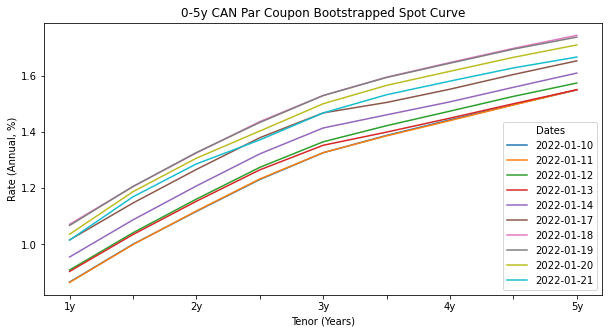

In [255]:
def par_boostrap(yld_data): #annualized w semi annual compounding
    dates = yld_data.index
    mats = yld_data.columns
    outer = []
    ytms = []
    count1=0
    for i in dates:
        # 6mo interp
        ytm_interp = []
        spot_rates = []
        yields = yld_data.iloc[count1,:]
        periods_to_mat = ((mats - i).days*2)/365 # approx (not incl leap years)
        interp = interp1d(periods_to_mat, yields, bounds_error=True, fill_value=scipy.nan)
        
        
        
        
        for j in np.arange(1,11,1):
            val = float(interp(j))
            if not np.isnan(val):
                ytm_interp.append(val)
        ytm_interp = np.array(ytm_interp)/100   
        
        for k in range(len(ytm_interp)):
            if k==0:
                spot = ytm_interp[0]
            else:
                sum_ = 0
                for m in range(k):
                    sum_ += (1/(1+spot_rates[m]/2)**(m+1))
                spot = (((ytm_interp[k]*100/2+100)/(100-100*ytm_interp[k]*sum_/2))**(1/(k+1))-1)*2
            
            spot_rates += [spot]
        ytms += [ytm_interp]    
        outer += [spot_rates]
        count1+=1
        
    #idx = []    
    idx = ['','1y','','2y','','3y','','4y','','5y']
    #for f in range(len(spot_rates)):
        #idx += [dates[0] + relativedelta(months=6*(f+1))]     
    
    outer = (pd.DataFrame(outer)*100)
    outer.columns = idx
    outer.index = px_data.index#.strftime('%Y-%m-%d')
    outer = outer.iloc[:,1:]
    outer.T.plot(figsize=(10,5), title = "0-5y CAN Par Coupon Bootstrapped Spot Curve",
                 xlabel="Tenor (Years)", ylabel="Rate (Annual, %)")
    
    ytms = (pd.DataFrame(ytms)*100)
    ytms.columns = idx
    ytms.index = px_data.index
    ytms = ytms.iloc[:,1:]

    return outer, ytms

spot, ytm = par_boostrap(outer)
spot

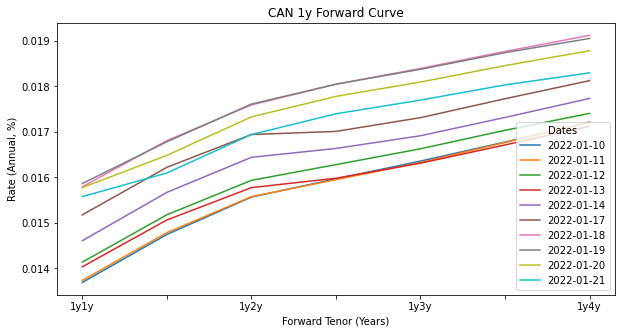

In [261]:
def fwd_rates(x): #annualized
    spot_rates = x
    cols = np.arange(1,10,1)
    spot_rates.columns = cols
    outer = []
    for j in spot_rates.index:
        inner = []
        yldcrv = np.array(spot_rates.T[j]/100)
        fwd = 0
        for i in np.arange(2,9,1):
            fwd = ((((1+yldcrv[i]/2)**(i+2))/((1+yldcrv[0]/2)**2))**(1/i)-1)*2     
            inner += [fwd]
        outer += [inner]

    outer = pd.DataFrame(outer)
    outer.index = spot_rates.index#.strftime('%Y-%m-%d')
    outer.columns = np.arange(1,4.5,0.5)
    outer.columns = ['1y1y','','1y2y','','1y3y','','1y4y']

    outer.T.plot(figsize=(10,5), title = "CAN 1y Forward Curve", xlabel = "Forward Tenor (Years)", ylabel = "Rate (Annual, %)")

    #outer.columns = ['1y1y','','1y2y','','1y3y','','1y4y']
    return outer
    
fwd = fwd_rates(spot)

In [264]:
fwd_log_ret = np.log(fwd.iloc[1:,[0,2,4,6]]/np.array(fwd.iloc[:-1,[0,2,4,6]]))
fwd_cov = fwd_log_ret.cov()
fwd_eig = np.linalg.eig(fwd_cov)


ytm_log_ret = np.log(ytm.iloc[1:,[0,2,4,6,8]]/np.array(ytm.iloc[:-1,[0,2,4,6,8]]))
ytm_cov = ytm_log_ret.cov()
ytm_eig = np.linalg.eig(ytm_cov)
#fwd_eig[1]

ytm_eig

(array([4.21015952e-03, 1.28548524e-04, 8.21740651e-06, 2.34823226e-06,
        1.53253214e-06]),
 array([[ 0.55437325, -0.58593202,  0.37641606,  0.44534641, -0.09659963],
        [ 0.42389126, -0.23560462, -0.09285772, -0.62889181,  0.60056574],
        [ 0.40892697, -0.06915095, -0.74023958, -0.08755631, -0.52189667],
        [ 0.43119109,  0.5278362 ,  0.50648751, -0.35516995, -0.39088092],
        [ 0.39979929,  0.56372087, -0.21261267,  0.52187151,  0.45257628]]))